### Challenge 32: Break HMAC-SHA1 with a slightly less artificial timing leak

[Back to Index](CryptoPalsWalkthroughs_Cobb.ipynb)

<div class="alert alert-block alert-warning">
    
## Work in progress.  This one's not working 100% reliably.
    
</div>

<div class="alert alert-block alert-info">
    
Reduce the sleep in your "insecure_compare" until your previous solution breaks. (Try 5ms to start.)

Now break it again.

</div>

In [14]:
from Crypto import Random
from matplotlib import pyplot as plt 
import cryptopals as cp
import numpy as np
import sha1
import requests
import time
import sys
from requests.exceptions import Timeout

I modified the "web server" from Challenge 31 to accept a delay time argument as well, to make this slightly easier to play with.

In [15]:
def check_file_hmac(file_name, hmac, delay_time):
    """Supply file_name and hmac as ascii strings -- hmac in hex.  Delay_time float in string format."""
    
    successFlag = False
    N_attempts = 0
    while successFlag == False:
        
        try:
            N_attempts += 1
            if N_attempts > 10:
                raise()
            start = time.time()
            #url = "http://192.168.4.176:1234?file=" + file_name + "&signature=" + hmac + "&delay_time=" + delay_time
            url = "http://localhost:1234?file=" + file_name + "&signature=" + hmac + "&delay_time=" + delay_time
            response = requests.get(url, timeout = 10)
            text = response.text
            successFlag = True
            end = time.time()
            time_elapsed = end - start
        except(ConnectionError, Exception, Timeout) as e:
            print("Exception getting url:", e)
            sys.exit(-1)
    
    if text=='500':
        return([False, time_elapsed])
    elif text=='200':
        return([True, time_elapsed])
    else:
        sys.exit(-1)

Test it out

In [16]:
file_name = '25.ipynb'
good_sig = '68105af4c1b8c32845079c3c06a32e9c0665ccb0'
[hmac_valid, time_elapsed] = check_file_hmac(file_name, good_sig, '0.01')

print(f"HMAC Valid: {hmac_valid}\nTime Elapsed: {time_elapsed}")

HMAC Valid: True
Time Elapsed: 2.4085137844085693


Still works, and accepts the ```delay_time``` argument successfully.

Let's try it with a much lower delay time and see what happens, just for the first byte of the HMAC to start:

Processing byte idx: 0


................................................................

................................................................

................................................................

................................................................

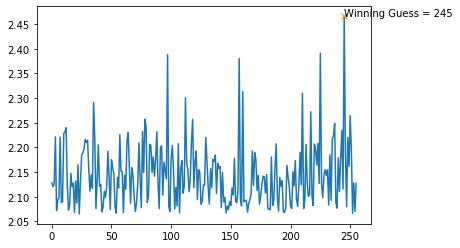

Time Elapsed:  548.9468765258789


In [17]:
file_name = 'challenge-data/6.txt'
N_Tests = 1
guess_times = np.zeros((1, N_Tests, 256))
hmac_guess = b''

f = open(file_name, 'r')
data = bytes(f.read(), 'ascii')
f.close()

for byte_idx in range(1):
    
    start2 = time.time()
    print(f"Processing byte idx: {byte_idx}")
    for byte_guess in range(256):
        if byte_guess % 64 == 0:
            print('\n')
        print('.',  end='')
        sig = hmac_guess + (byte_guess).to_bytes(1, 'little')
        sig = sig + b'\x00'*(20-len(sig))
        sig = sig.hex()
        for guess_idx in range(N_Tests):
            [hmac_valid, time_elapsed] = check_file_hmac(file_name, sig, '0.05')
            #[hmac_valid, time_elapsed] = check_file_hmac(data, sig)
            guess_times[byte_idx][guess_idx][byte_guess] = time_elapsed
            if hmac_valid:
                break
        if hmac_valid:
            best_guess = byte_guess
            break
    
    if not(hmac_valid):
        tmp = np.average(guess_times[byte_idx][:][:], axis=0)    
        best_guess = tmp.argmax()
    
    hmac_guess += int(best_guess).to_bytes(1, 'little')
        
    plt.plot(range(256), tmp)
    label_text = 'Winning Guess = ' + str(best_guess)
    plt.plot(best_guess, tmp[best_guess], 'x')
    plt.text(best_guess, tmp[best_guess], label_text)
    plt.show()
    end2 = time.time()
    print(f"Time Elapsed:  {end2-start2}")

Well, that didn't work very well.  The time difference is lost in the noise.  I'll try it again, but with several measurements averaged together.

Processing byte idx: 0


................................................................

................................................................

................................................................

................................................................

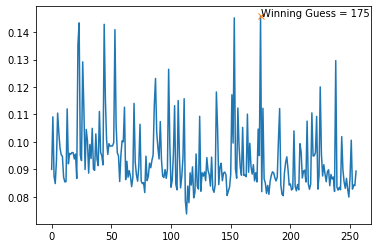

Time Elapsed:  240.16854619979858


In [88]:
file_name = 'challenge-data/6.txt'
N_Tests = 10
guess_times = np.zeros((1, N_Tests, 256))
hmac_guess = b''

f = open(file_name, 'r')
data = bytes(f.read(), 'ascii')
f.close()

for byte_idx in range(1):
    
    start2 = time.time()
    print(f"Processing byte idx: {byte_idx}")
    for byte_guess in range(256):
        if byte_guess % 64 == 0:
            print('\n')
        print('.',  end='')
        sig = hmac_guess + (byte_guess).to_bytes(1, 'little')
        sig = sig + b'\x00'*(20-len(sig))
        sig = sig.hex()
        for guess_idx in range(N_Tests):
            [hmac_valid, time_elapsed] = check_file_hmac(file_name, sig, '0.005')
            #[hmac_valid, time_elapsed] = check_file_hmac(data, sig)
            guess_times[byte_idx][guess_idx][byte_guess] = time_elapsed
            if hmac_valid:
                break
        if hmac_valid:
            best_guess = byte_guess
            break
    
    if not(hmac_valid):
        tmp = np.average(guess_times[byte_idx][:][:], axis=0)    
        best_guess = tmp.argmax()
    
    hmac_guess += int(best_guess).to_bytes(1, 'little')
        
    plt.plot(range(256), tmp)
    label_text = 'Winning Guess = ' + str(best_guess)
    plt.plot(best_guess, tmp[best_guess], 'x')
    plt.text(best_guess, tmp[best_guess], label_text)
    plt.show()
    end2 = time.time()
    print(f"Time Elapsed:  {end2-start2}")

---

### Averaging out the noise

Still lots of problems, and at least on my computer -- with the server on the same computer, error prone.

Adding a threshold for the min delta time between the best and next-best ranked candidate bytes.  This version will continue gathering data for a particular byte until the delta exceeds that threshold.  It also allows asking for a minimum # of tests before checking.

IntProgress(value=0, description='Byte 0:', max=256)

Test: 1, Diff: 0.0040056705474853516


IntProgress(value=0, description='Byte 0:', max=256)

Test: 2, Diff: 0.0014901161193847656


IntProgress(value=0, description='Byte 0:', max=256)

Test: 3, Diff: 0.00018755594889322916


IntProgress(value=0, description='Byte 0:', max=256)

Test: 4, Diff: 0.000133514404296875


IntProgress(value=0, description='Byte 0:', max=256)

Test: 5, Diff: 0.0013201713562011718


IntProgress(value=0, description='Byte 0:', max=256)

Test: 6, Diff: 0.000826557477315267


IntProgress(value=0, description='Byte 0:', max=256)

Test: 7, Diff: 0.0008948189871651786


IntProgress(value=0, description='Byte 0:', max=256)

Test: 8, Diff: 0.0015328526496887207


IntProgress(value=0, description='Byte 0:', max=256)

Test: 9, Diff: 0.0023598670959472656


IntProgress(value=0, description='Byte 0:', max=256)

Test: 10, Diff: 0.002003192901611328


IntProgress(value=0, description='Byte 0:', max=256)

Test: 11, Diff: 0.0019354603507302024


IntProgress(value=0, description='Byte 0:', max=256)

Test: 12, Diff: 0.002107560634613037


IntProgress(value=0, description='Byte 0:', max=256)

Test: 13, Diff: 0.0024312642904428337


IntProgress(value=0, description='Byte 0:', max=256)

Test: 14, Diff: 0.0020431450435093473


IntProgress(value=0, description='Byte 0:', max=256)

Test: 15, Diff: 0.002238162358601888


IntProgress(value=0, description='Byte 0:', max=256)

Test: 16, Diff: 0.002474382519721985


IntProgress(value=0, description='Byte 0:', max=256)

Test: 17, Diff: 0.0032561105840346392


IntProgress(value=0, description='Byte 0:', max=256)

Test: 18, Diff: 0.003068473603990343


IntProgress(value=0, description='Byte 0:', max=256)

Test: 19, Diff: 0.0032203448446173418


IntProgress(value=0, description='Byte 0:', max=256)

Test: 20, Diff: 0.0032629847526550295


IntProgress(value=0, description='Byte 0:', max=256)

Test: 21, Diff: 0.00333971068972633


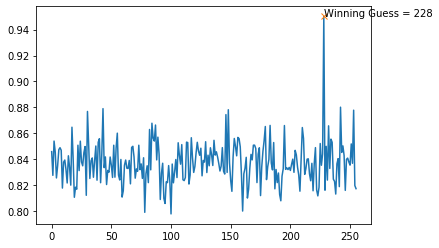

Time Elapsed:  217.31005001068115


IntProgress(value=0, description='Byte 1:', max=256)

Test: 1, Diff: 0.0007474422454833984


IntProgress(value=0, description='Byte 1:', max=256)

Test: 2, Diff: 0.0009878873825073242


IntProgress(value=0, description='Byte 1:', max=256)

Test: 3, Diff: 0.0003341833750406901


IntProgress(value=0, description='Byte 1:', max=256)

Test: 4, Diff: 1.5497207641601562e-06


IntProgress(value=0, description='Byte 1:', max=256)

Test: 5, Diff: 0.0002063751220703125


IntProgress(value=0, description='Byte 1:', max=256)

Test: 6, Diff: 0.0001293818155924479


IntProgress(value=0, description='Byte 1:', max=256)

Test: 7, Diff: 0.0016762869698660715


IntProgress(value=0, description='Byte 1:', max=256)

Test: 8, Diff: 0.0021521151065826416


IntProgress(value=0, description='Byte 1:', max=256)

Test: 9, Diff: 0.0024450355105929905


IntProgress(value=0, description='Byte 1:', max=256)

Test: 10, Diff: 0.0025922775268554686


IntProgress(value=0, description='Byte 1:', max=256)

Test: 11, Diff: 0.0029000152241099963


IntProgress(value=0, description='Byte 1:', max=256)

Test: 12, Diff: 0.002896289030710856


IntProgress(value=0, description='Byte 1:', max=256)

Test: 13, Diff: 0.0029477706322303186


IntProgress(value=0, description='Byte 1:', max=256)

Test: 14, Diff: 0.0031269959041050504


IntProgress(value=0, description='Byte 1:', max=256)

Test: 15, Diff: 0.003161764144897461


IntProgress(value=0, description='Byte 1:', max=256)

Test: 16, Diff: 0.0026530474424362183


IntProgress(value=0, description='Byte 1:', max=256)

Test: 17, Diff: 0.0028499154483570773


IntProgress(value=0, description='Byte 1:', max=256)

Test: 18, Diff: 0.002999252743191189


IntProgress(value=0, description='Byte 1:', max=256)

Test: 19, Diff: 0.0030488089511269017


IntProgress(value=0, description='Byte 1:', max=256)

Test: 20, Diff: 0.0033685088157653807


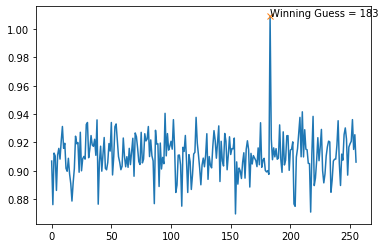

Time Elapsed:  235.82830715179443


IntProgress(value=0, description='Byte 2:', max=256)

Test: 1, Diff: 0.0009562969207763672


IntProgress(value=0, description='Byte 2:', max=256)

Test: 2, Diff: 3.1828880310058594e-05


IntProgress(value=0, description='Byte 2:', max=256)

Test: 3, Diff: 0.0005910396575927734


IntProgress(value=0, description='Byte 2:', max=256)

Test: 4, Diff: 0.0024449825286865234


IntProgress(value=0, description='Byte 2:', max=256)

Test: 5, Diff: 0.003101682662963867


IntProgress(value=0, description='Byte 2:', max=256)

Test: 6, Diff: 0.003446777661641439


IntProgress(value=0, description='Byte 2:', max=256)

Test: 7, Diff: 0.0037212371826171875


IntProgress(value=0, description='Byte 2:', max=256)

Test: 8, Diff: 0.0022515058517456055


IntProgress(value=0, description='Byte 2:', max=256)

Test: 9, Diff: 0.0024485058254665798


IntProgress(value=0, description='Byte 2:', max=256)

Test: 10, Diff: 0.002493929862976074


IntProgress(value=0, description='Byte 2:', max=256)

Test: 11, Diff: 0.002601211721246893


IntProgress(value=0, description='Byte 2:', max=256)

Test: 12, Diff: 0.0025506019592285156


IntProgress(value=0, description='Byte 2:', max=256)

Test: 13, Diff: 0.0028159251579871545


IntProgress(value=0, description='Byte 2:', max=256)

Test: 14, Diff: 0.0030387299401419504


IntProgress(value=0, description='Byte 2:', max=256)

Test: 15, Diff: 0.0032378196716308593


IntProgress(value=0, description='Byte 2:', max=256)

Test: 16, Diff: 0.003411710262298584


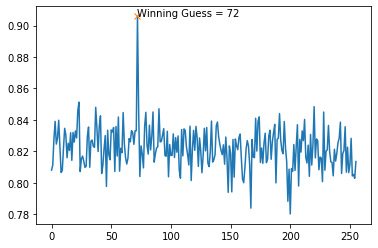

Time Elapsed:  212.69145607948303


IntProgress(value=0, description='Byte 3:', max=256)

Test: 1, Diff: 0.0005838871002197266


IntProgress(value=0, description='Byte 3:', max=256)

Test: 2, Diff: 1.0848045349121094e-05


IntProgress(value=0, description='Byte 3:', max=256)

Test: 3, Diff: 0.0016660690307617188


IntProgress(value=0, description='Byte 3:', max=256)

Test: 4, Diff: 0.002033829689025879


IntProgress(value=0, description='Byte 3:', max=256)

Test: 5, Diff: 0.0026360511779785155


IntProgress(value=0, description='Byte 3:', max=256)

Test: 6, Diff: 0.002535541852315267


IntProgress(value=0, description='Byte 3:', max=256)

Test: 7, Diff: 0.0021214144570486887


IntProgress(value=0, description='Byte 3:', max=256)

Test: 8, Diff: 0.0023511946201324463


IntProgress(value=0, description='Byte 3:', max=256)

Test: 9, Diff: 0.004596710205078125


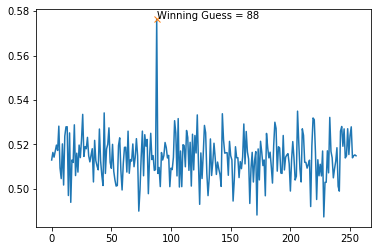

Time Elapsed:  132.8919472694397


IntProgress(value=0, description='Byte 4:', max=256)

Test: 1, Diff: 1.6689300537109375e-06


IntProgress(value=0, description='Byte 4:', max=256)

Test: 2, Diff: 0.0015170574188232422


IntProgress(value=0, description='Byte 4:', max=256)

Test: 3, Diff: 0.00033164024353027344


IntProgress(value=0, description='Byte 4:', max=256)

Test: 4, Diff: 0.002064347267150879


IntProgress(value=0, description='Byte 4:', max=256)

Test: 5, Diff: 0.0008501529693603516


IntProgress(value=0, description='Byte 4:', max=256)

Test: 6, Diff: 0.002039750417073568


IntProgress(value=0, description='Byte 4:', max=256)

Test: 7, Diff: 0.0023814610072544645


IntProgress(value=0, description='Byte 4:', max=256)

Test: 8, Diff: 0.006969749927520752


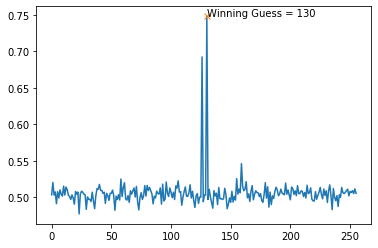

Time Elapsed:  130.56331586837769


IntProgress(value=0, description='Byte 5:', max=256)

Test: 1, Diff: 0.13597512245178223


IntProgress(value=0, description='Byte 5:', max=256)

Test: 2, Diff: 0.03055751323699951


IntProgress(value=0, description='Byte 5:', max=256)

Test: 3, Diff: 0.01694329579671224


IntProgress(value=0, description='Byte 5:', max=256)

Test: 4, Diff: 0.012702405452728271


IntProgress(value=0, description='Byte 5:', max=256)

Test: 5, Diff: 0.00979313850402832


IntProgress(value=0, description='Byte 5:', max=256)

Test: 6, Diff: 0.00827650229136149


IntProgress(value=0, description='Byte 5:', max=256)

Test: 7, Diff: 0.005667993000575474


IntProgress(value=0, description='Byte 5:', max=256)

Test: 8, Diff: 0.002700507640838623


IntProgress(value=0, description='Byte 5:', max=256)

Test: 9, Diff: 0.0024002393086751304


IntProgress(value=0, description='Byte 5:', max=256)

Test: 10, Diff: 0.0031584978103637697


IntProgress(value=0, description='Byte 5:', max=256)

Test: 11, Diff: 0.0026891881769353695


IntProgress(value=0, description='Byte 5:', max=256)

Test: 12, Diff: 0.0024788379669189453


IntProgress(value=0, description='Byte 5:', max=256)

Test: 13, Diff: 0.002366744554959811


IntProgress(value=0, description='Byte 5:', max=256)

Test: 14, Diff: 0.00219764028276716


IntProgress(value=0, description='Byte 5:', max=256)

Test: 15, Diff: 0.0021829922993977864


IntProgress(value=0, description='Byte 5:', max=256)

Test: 16, Diff: 0.0019629597663879395


IntProgress(value=0, description='Byte 5:', max=256)

Test: 17, Diff: 0.001787283841301413


IntProgress(value=0, description='Byte 5:', max=256)

Test: 18, Diff: 0.0016891823874579535


IntProgress(value=0, description='Byte 5:', max=256)

Test: 19, Diff: 0.001598282864219264


IntProgress(value=0, description='Byte 5:', max=256)

Test: 20, Diff: 0.001557326316833496


IntProgress(value=0, description='Byte 5:', max=256)

Test: 21, Diff: 0.0014822823660714285


IntProgress(value=0, description='Byte 5:', max=256)

Test: 22, Diff: 0.0013720880855213511


IntProgress(value=0, description='Byte 5:', max=256)

Test: 23, Diff: 0.0011801305024520211


IntProgress(value=0, description='Byte 5:', max=256)

Test: 24, Diff: 0.0004978577295939127


IntProgress(value=0, description='Byte 5:', max=256)

Test: 25, Diff: 0.0005564403533935547


IntProgress(value=0, description='Byte 5:', max=256)

Test: 26, Diff: 0.0004205153538630559


IntProgress(value=0, description='Byte 5:', max=256)

Test: 27, Diff: 0.00044269914980287904


IntProgress(value=0, description='Byte 5:', max=256)

Test: 28, Diff: 0.002625150339944022


IntProgress(value=0, description='Byte 5:', max=256)

Test: 29, Diff: 0.011852954996043238


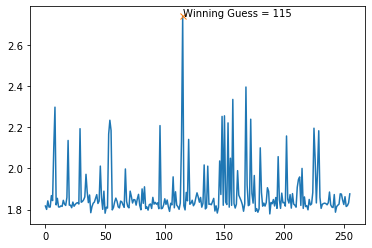

Time Elapsed:  483.8695070743561


IntProgress(value=0, description='Byte 6:', max=256)

Test: 1, Diff: 0.36534571647644043


IntProgress(value=0, description='Byte 6:', max=256)

Test: 2, Diff: 0.02584385871887207


IntProgress(value=0, description='Byte 6:', max=256)

Test: 3, Diff: 0.017555077870686848


IntProgress(value=0, description='Byte 6:', max=256)

Test: 4, Diff: 0.01316601037979126


IntProgress(value=0, description='Byte 6:', max=256)

Test: 5, Diff: 0.0002895832061767578


IntProgress(value=0, description='Byte 6:', max=256)

Test: 6, Diff: 0.00024120012919108072


IntProgress(value=0, description='Byte 6:', max=256)

Test: 7, Diff: 0.00020701544625418528


IntProgress(value=0, description='Byte 6:', max=256)

Test: 8, Diff: 0.018971294164657593


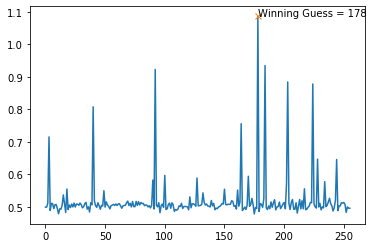

Time Elapsed:  134.06091952323914


IntProgress(value=0, description='Byte 7:', max=256)

Test: 1, Diff: 0.02461528778076172


IntProgress(value=0, description='Byte 7:', max=256)

Test: 2, Diff: 0.04489552974700928


IntProgress(value=0, description='Byte 7:', max=256)

Test: 3, Diff: 0.029259284337361652


IntProgress(value=0, description='Byte 7:', max=256)

Test: 4, Diff: 0.0028415322303771973


IntProgress(value=0, description='Byte 7:', max=256)

Test: 5, Diff: 0.038401222229003905


IntProgress(value=0, description='Byte 7:', max=256)

Test: 6, Diff: 0.031671365102132164


IntProgress(value=0, description='Byte 7:', max=256)

Test: 7, Diff: 0.02786081177847726


IntProgress(value=0, description='Byte 7:', max=256)

Test: 8, Diff: 0.0170002281665802


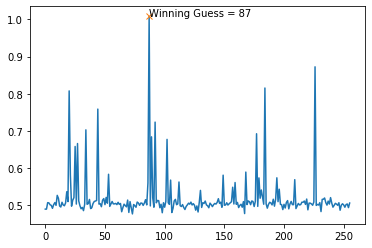

Time Elapsed:  133.89709186553955


IntProgress(value=0, description='Byte 8:', max=256)

Test: 1, Diff: 0.28697681427001953


IntProgress(value=0, description='Byte 8:', max=256)

Test: 2, Diff: 0.14401030540466309


IntProgress(value=0, description='Byte 8:', max=256)

Test: 3, Diff: 0.03485663731892904


IntProgress(value=0, description='Byte 8:', max=256)

Test: 4, Diff: 0.0007270574569702148


IntProgress(value=0, description='Byte 8:', max=256)

Test: 5, Diff: 0.0005758762359619141


IntProgress(value=0, description='Byte 8:', max=256)

Test: 6, Diff: 0.00031248728434244793


IntProgress(value=0, description='Byte 8:', max=256)

Test: 7, Diff: 1.9652502877371652e-05


IntProgress(value=0, description='Byte 8:', max=256)

Test: 8, Diff: 0.00023281574249267578


IntProgress(value=0, description='Byte 8:', max=256)

Test: 9, Diff: 2.166959974500868e-05


IntProgress(value=0, description='Byte 8:', max=256)

Test: 10, Diff: 6.65426254272461e-05


IntProgress(value=0, description='Byte 8:', max=256)

Test: 11, Diff: 0.0006027655168013139


IntProgress(value=0, description='Byte 8:', max=256)

Test: 12, Diff: 0.00011247396469116211


IntProgress(value=0, description='Byte 8:', max=256)

Test: 13, Diff: 0.00023227471571702225


IntProgress(value=0, description='Byte 8:', max=256)

Test: 14, Diff: 0.0026251929146902902


IntProgress(value=0, description='Byte 8:', max=256)

Test: 15, Diff: 0.0021157105763753253


IntProgress(value=0, description='Byte 8:', max=256)

Test: 16, Diff: 0.0018278062343597412


IntProgress(value=0, description='Byte 8:', max=256)

Test: 17, Diff: 0.00134737351361443


IntProgress(value=0, description='Byte 8:', max=256)

Test: 18, Diff: 0.0012739366955227321


IntProgress(value=0, description='Byte 8:', max=256)

Test: 19, Diff: 0.0011289370687384355


IntProgress(value=0, description='Byte 8:', max=256)

Test: 20, Diff: 0.0009723901748657227


IntProgress(value=0, description='Byte 8:', max=256)

Test: 21, Diff: 0.0009247348422095889


IntProgress(value=0, description='Byte 8:', max=256)

Test: 22, Diff: 0.0008823221380060369


IntProgress(value=0, description='Byte 8:', max=256)

Test: 23, Diff: 0.0008427371149477751


IntProgress(value=0, description='Byte 8:', max=256)

Test: 24, Diff: 0.0007677872975667318


IntProgress(value=0, description='Byte 8:', max=256)

Test: 25, Diff: 0.00031124114990234376


IntProgress(value=0, description='Byte 8:', max=256)

Test: 26, Diff: 4.598727593055138e-05


IntProgress(value=0, description='Byte 8:', max=256)

Test: 27, Diff: 1283.1637358577163


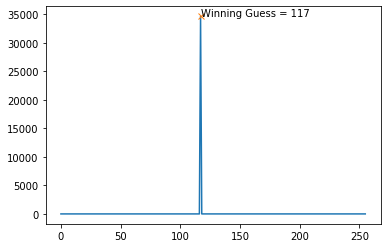

Time Elapsed:  35104.143365859985


IntProgress(value=0, description='Byte 9:', max=256)

Test: 1, Diff: 0.0009834766387939453


IntProgress(value=0, description='Byte 9:', max=256)

Test: 2, Diff: 4.0411949157714844e-05


IntProgress(value=0, description='Byte 9:', max=256)

Test: 3, Diff: 0.0739580790201823


IntProgress(value=0, description='Byte 9:', max=256)

Test: 4, Diff: 0.0009319186210632324


IntProgress(value=0, description='Byte 9:', max=256)

Test: 5, Diff: 0.0017424583435058593


IntProgress(value=0, description='Byte 9:', max=256)

Test: 6, Diff: 0.0014191468556722004


IntProgress(value=0, description='Byte 9:', max=256)

Test: 7, Diff: 0.0007837499891008649


IntProgress(value=0, description='Byte 9:', max=256)

KeyboardInterrupt: 

In [81]:
file_name = 'challenge-data/6.txt'
MIN_TESTS = 8
N_BYTES = 20
DELAY_TIME = 0.005
MIN_DIF = delay_time * (.9)

guess_times = np.zeros((N_BYTES, 256))
hmac_guess = b''

guess_list = list(range(256))

for byte_idx in range(N_BYTES):
    
    start2 = time.time()

    test_idx = 0
    longest_time = 1
    next_longest_time = 1
    
    while (test_idx < MIN_TESTS) or (this_dif < min_dif):
        
        # Shuffle the order we'll check guesses
        random.shuffle(guess_list)

        progress = widgets.IntProgress(
            value=0,
            min=0,
            max=256,
            step=1,
            description='Byte ' + str(byte_idx) + ':',
            bar_style='', 
            orientation='horizontal'
            )
        display(progress)

        for byte_guess in guess_list:
            
            progress.value += 1
            
            sig = hmac_guess + (byte_guess).to_bytes(1, 'little')
            sig = sig + b'\x00'*(N_BYTES - len(sig))
            sig = sig.hex()
            
            [hmac_valid, time_elapsed] = check_file_hmac(file_name, sig, str(delay_time))            
            if hmac_valid and (byte_idx == N_Bytes):                
                break
            
            guess_times[byte_idx][byte_guess] += time_elapsed
            
        if hmac_valid and (byte_idx == N_BYTES):
            best_guess = byte_guess
            break            
    
        test_idx += 1
        x = guess_times[byte_idx][:].copy()
        x.sort()
        longest_time = x[-1]
        next_longest_time = x[-2]
        this_dif = (longest_time - next_longest_time) / test_idx
        print(f"Test: {test_idx}, Diff: {this_dif}")
    
    if not(hmac_valid) or (byte_idx != N_BYTES):
        best_guess = guess_times[byte_idx][:].argmax()
    
    hmac_guess += int(best_guess).to_bytes(1, 'little')
        
    plt.plot(range(256), guess_times[byte_idx][:])
    label_text = 'Winning Guess = ' + str(best_guess)
    plt.plot(best_guess, guess_times[byte_idx][best_guess], 'x')
    plt.text(best_guess, guess_times[byte_idx][best_guess], label_text)
    plt.show()
    end2 = time.time()
    print(f"Time Elapsed:  {end2-start2}")

In [ ]:
[hmac_valid, time_elapsed] = check_file_hmac(file_name, hmac_guess.hex())
print(f"HMAC Valid = {hmac_valid}")

[Back to Index](CryptoPalsWalkthroughs_Cobb.ipynb)